<a href="https://colab.research.google.com/github/vishal19217/CyberBullying_Sentiment_Analysis/blob/main/LSTM-Word2Vec-GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Libraries for implementing LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization & word embeddings library
from collections import Counter
from gensim.models import Word2Vec

In [50]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/processed-tweets.csv', index_col=0)
data = data[data['Basic clean'].notna()]
data.head(20)

,Basic clean,sentiment,tweet_length
0,words katandandre food crapilicious mkr,not_cyberbullying,5
1,aussietv white mkr theblock today sunrise stud...,not_cyberbullying,10
2,classy whore red velvet cupcakes,not_cyberbullying,5
3,meh p thanks heads concerned another angry dud...,not_cyberbullying,9
4,isis account pretending kurdish account like i...,not_cyberbullying,8
5,yes test god good bad indifferent weird whatev...,not_cyberbullying,11
6,itu sekolah ya bukan tempat bully ga jauh kaya...,not_cyberbullying,10
7,karma hope bites kat butt nasty mkr,not_cyberbullying,7
8,everything mostly priest,not_cyberbullying,3
9,rebecca black drops school due bullying,not_cyberbullying,6


In [51]:
data['sentiment'] = data['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4,'other_cyberbullying':5})

In [52]:
sentiments = ["religion","age","ethnicity","gender","not bullying","other_cyberbullying"]

In [53]:
X = data['Basic clean']
Y = data['sentiment']

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)  # train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)  # train-val split 

In [55]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [56]:
np.array(X_train).reshape(-1, 1)

array([['fuck yes thanks burfict pacman jones giving us dumb fucking niggers'],
       ['hate bullys say school done bullys thats bunch bs everywhere family work neighborhood go difference adult ill throw hands idc none em hurt'],
       ['rt xxxtentacion fan base fucking cancerous'],
       ...,
       ['wfh public transit tofrom vancouver'],
       ['since questioned clear talking supporters people opinions'],
       ['sorry journalists kind place vent gtgt like really lt3']],
      dtype=object)

In [57]:
train_os

,text_clean,sentiment
0,fuck yes thanks burfict pacman jones giving us...,2
1,hate bullys say school done bullys thats bunch...,1
2,rt xxxtentacion fan base fucking cancerous,5
3,anyone video white girl sho bullied high schoo...,1
4,retweeted want clarify nurses ive met lovely p...,1
...,...,...
34327,pissed sick sleep,5
34328,someone said going attend supernova instead do...,5
34329,wfh public transit tofrom vancouver,5
34330,since questioned clear talking supporters peop...,5


In [58]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [59]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5722],
       [   1, 5722],
       [   2, 5722],
       [   3, 5722],
       [   4, 5722],
       [   5, 5722]])

In [60]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [61]:
max_len = np.max(data['tweet_length'])
max_len

100

In [62]:
vocabulary, tokenized_column = Tokenize(data['Basic clean'], max_len)

In [63]:
vocabulary

[('school', 8620),
 ('like', 5742),
 ('fuck', 5583),
 ('dumb', 5136),
 ('high', 5012),
 ('people', 4727),
 ('bullied', 4618),
 ('nigger', 4158),
 ('rape', 4089),
 ('u', 4056),
 ('rt', 4041),
 ('gay', 3830),
 ('bully', 3544),
 ('jokes', 3407),
 ('one', 3356),
 ('girls', 2776),
 ('get', 2762),
 ('ass', 2709),
 ('girl', 2695),
 ('black', 2672),
 ('would', 2572),
 ('amp', 2538),
 ('muslims', 2392),
 ('muslim', 2350),
 ('mkr', 2333),
 ('know', 2256),
 ('white', 2144),
 ('think', 2047),
 ('bitch', 2002),
 ('idiot', 1984),
 ('joke', 1906),
 ('right', 1800),
 ('im', 1713),
 ('say', 1711),
 ('dont', 1677),
 ('got', 1660),
 ('call', 1648),
 ('women', 1648),
 ('fucking', 1631),
 ('even', 1617),
 ('go', 1601),
 ('bullies', 1592),
 ('make', 1565),
 ('christian', 1528),
 ('never', 1490),
 ('called', 1485),
 ('ur', 1483),
 ('see', 1478),
 ('shit', 1465),
 ('idiots', 1459),
 ('woman', 1457),
 ('time', 1426),
 ('still', 1391),
 ('really', 1380),
 ('want', 1378),
 ('first', 1299),
 ('hate', 1293),
 ('is

In [64]:
data["Basic clean"].iloc[197]

'perfect seat class would one surrounded best friend crush'

In [65]:
tokenized_column[197]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  931, 2832,  223,   21,   15, 4765,  212,  196,
        955])

In [66]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [67]:
EMBEDDING_DIM = 200

In [68]:
word2vec_model = Word2Vec(Word2vec_train_data, size=EMBEDDING_DIM)

In [69]:
Vocab_size = len(vocabulary)+1

In [70]:
#define empty embedding matrix
embedding_matrix = np.zeros((Vocab_size, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (45552, 200)


In [71]:
! pip install glove-python-binary

In [72]:
tweet_text = []
tweet_sentiment = []
for key, value in data.iterrows():
  tweet = value['Basic clean'].split()
  tweet_text.append(tweet)
  tweet_sentiment.append(value['sentiment'])

In [73]:
from glove import Corpus, Glove

corpus = Corpus()  # Creating a corpus object that will generate the co-occurence matrix
corpus.fit(tweet_text, window = 10)  # Training the corpus to generate the co-occurence matrix that will be used by GloVe
glove = Glove(no_components=200, learning_rate=0.05)  # Creating a glove object that will use the matrix created above to create embeddings
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)  # Training glove to create embeddings
glove.add_dictionary(corpus.dictionary)  # Adding corpus dictionary to glove dictionary
glove.save('glove.model')  # Saving the model

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [74]:
glove_embedding_matrix = np.random.random((len(vocabulary)+1, EMBEDDING_DIM))
count = 0
for word, token in vocabulary:
  embedding_vector = glove.word_vectors[glove.dictionary[word]]
  if embedding_vector is not None:
    count += 1
    glove_embedding_matrix[token] = embedding_vector
print("Completed!")
print("Number of words present in GloVe embeddings = "+str(count))

Completed!
Number of words present in GloVe embeddings = 45551


In [75]:
X = tokenized_column
y = data['sentiment'].values

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [77]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [78]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [79]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5722],
       [   1, 5722],
       [   2, 5722],
       [   3, 5722],
       [   4, 5722],
       [   5, 5722]])

In [80]:
print(type(X_train_os))
print(type(y_train_os))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [81]:
print(X_train_os.shape)
print(y_train_os.shape)

(34332, 100)
(34332,)


In [82]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [83]:
len(X_train_os[0])

100

In [84]:
Batch_size = 32

In [85]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=Batch_size, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=Batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=Batch_size, drop_last=True)

In [95]:
NUM_CLASSES = 6 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [96]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden    

In [97]:
model = BiLSTM_Sentiment_Classifier(Vocab_size, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, Batch_size, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(glove_embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(45552, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [98]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [99]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

#lists to host the train and validation losses of every batch for each epoch
train_loss, valid_loss  = [], []
#lists to host the train and validation accuracy of every batch for each epoch
train_acc, valid_acc  = [], []

for e in range(EPOCHS):

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0

    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set

        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases

    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 77.984234).  Saving model ...
	Train_loss : 0.9975 Val_loss : 0.5280
	Train_acc : 58.792% Val_acc : 77.984%
Epoch 2:Validation accuracy increased (77.984234 --> 79.124437).  Saving model ...
	Train_loss : 0.7285 Val_loss : 0.4886
	Train_acc : 69.910% Val_acc : 79.124%
Epoch 3:Validation accuracy increased (79.124437 --> 80.161411).  Saving model ...
	Train_loss : 0.6074 Val_loss : 0.4754
	Train_acc : 75.197% Val_acc : 80.161%
Epoch 4:Validation accuracy increased (80.161411 --> 80.546171).  Saving model ...
	Train_loss : 0.5248 Val_loss : 0.4736
	Train_acc : 78.843% Val_acc : 80.546%
Epoch 5:Validation accuracy increased (80.546171 --> 80.805180).  Saving model ...
	Train_loss : 0.4621 Val_loss : 0.4805
	Train_acc : 81.562% Val_acc : 80.805%


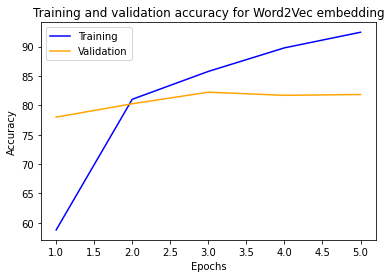

In [100]:
import matplotlib.pyplot as plt

xpoints = np.array([1, 2, 3, 4, 5])
ypoints_train = np.array(train_acc)
ypoints_val = np.array(valid_acc)
plt.plot(xpoints, ypoints_train, color="blue", label = "Training")
plt.plot(xpoints, ypoints_val, color="orange", label= "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy for Word2Vec embedding")
plt.legend()
plt.show()

In [101]:
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [102]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

In [103]:
from sklearn.metrics import classification_report
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Classification Report for Bi-LSTM :
                      precision    recall  f1-score   support

           religion       0.92      0.94      0.93      1590
                age       0.95      0.97      0.96      1578
          ethnicity       0.99      0.97      0.98      1549
             gender       0.86      0.85      0.85      1523
       not bullying       0.61      0.59      0.60      1529
other_cyberbullying       0.55      0.57      0.56      1159

           accuracy                           0.83      8928
          macro avg       0.81      0.81      0.81      8928
       weighted avg       0.83      0.83      0.83      8928

